In [10]:
# call the library

# to generate data processing and visualization tools
import matplotlib.pyplot as plt
import pandas as pd

# parsing and timing utilities
import ast
import string

# text processing and visualization
import nltk

from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords

nltk.download('stopwords')

# monitoring
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Retrived Dataset**

In [11]:
# retrieve the cleaned dataset
drug_reviews = pd.read_csv('cleaned dataset.csv')
drug_reviews.shape

(215061, 11)

In [12]:
# check for null and duplication

print("The number of missing rows are: ", drug_reviews.isnull().sum().sum())
print("The number of duplicated rows are: ", drug_reviews.duplicated().sum())

The number of missing rows are:  94
The number of duplicated rows are:  0


In [13]:
# fill the missing columns with blank ""
drug_reviews.fillna("", inplace=True)

# check the missing values
print("The number of missing rows are: ", drug_reviews.isnull().sum().sum())

The number of missing rows are:  0


In [14]:
drug_reviews.head()

,drugName,condition,review,rating,date,usefulCount,cleaned review,TextBlob_Polarity,Sentiment Category,side effects,effectiveness
0,valsartan,left ventricular dysfunction,"""it has no side effect, i take it in combinati...",9,20/5/2012,27,`` side effect take combin bystol 5 mg fish oi...,0.000000,1,['no side effect'],"['combination of bystolic 5 mg', 'fish oil']"
1,guanfacine,adhd,"""my son is halfway through his fourth week of ...",8,27/4/2010,192,`` son halfway fourth week intuniv becam conce...,0.156667,2,"['could hardly get out of bed', 'very cranky',...","['much more agreeable', 'overall his behavior ..."
2,lybrel,birth control,"""i used to take another oral contraceptive, wh...",5,14/12/2009,17,`` use take anoth oral contracept 21 pill cycl...,0.120833,2,"['two weeks of period', 'daily brown discharge...","['very light periods', 'period free was tempti..."
3,ortho evra,birth control,"""this is my first time using any form of birth...",8,3/11/2015,10,`` first time use form birth control 039 glad ...,0.300000,2,"['decreased libido', 'longer periods (5-6 days...",['happy with the patch']
4,buprenorphine / naloxone,opiate dependence,"""suboxone has completely turned my life around...",9,27/11/2016,37,`` suboxon complet turn life around feel healt...,0.147037,2,"['minimal side-effects', 'slight constipation'...","['completely turned my life around', 'feel hea..."


# **Data Processing**

In [15]:
def filter_data(df, 
                min_useful_count=None, 
                min_ratings=None, 
                min_drug_frequency=None, 
                min_condition_frequency=None):
    
    """
    Filters the drug reviews DataFrame based on given criteria:
    - Minimum usefulCount (number of helpful votes)
    - Minimum rating threshold
    - Minimum frequency for drugs to keep
    - Minimum frequency for conditions to keep
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with drug reviews.
        min_useful_count (int, optional): Minimum usefulCount to keep reviews.
        min_ratings (float or int, optional): Minimum rating to keep reviews.
        min_drug_frequency (int, optional): Minimum number of times a drug must appear.
        min_condition_frequency (int, optional): Minimum number of times a condition must appear.
        
    Returns:
        pd.DataFrame: Filtered DataFrame after applying all criteria.
    """
    
    filtered_drug_reviews = drug_reviews.copy()
    
    if min_useful_count is not None:
        filtered_drug_reviews = filtered_drug_reviews[filtered_drug_reviews['usefulCount'] >= min_useful_count]
        print(f"Filtered reviews with usefulCount >= {min_useful_count}: {filtered_drug_reviews.shape[0]} reviews")

    if min_ratings is not None:
        filtered_drug_reviews = filtered_drug_reviews[filtered_drug_reviews['rating'] > min_ratings]
        print(f"Filtered reviews with valid ratings > {min_ratings}: {filtered_drug_reviews.shape[0]} reviews")
    
    if min_drug_frequency is not None:
        drug_counts = filtered_drug_reviews['drugName'].value_counts()
        frequent_drugs = drug_counts[drug_counts > min_drug_frequency].index
        filtered_drug_reviews = filtered_drug_reviews[filtered_drug_reviews['drugName'].isin(frequent_drugs)]
        print(f"Filtered reviews with drugs appearing more than {min_drug_frequency} times: {filtered_drug_reviews.shape[0]} reviews")

    if min_condition_frequency is not None:
        cond_counts = filtered_drug_reviews['condition'].value_counts()
        frequent_conds = cond_counts[cond_counts > min_condition_frequency].index
        filtered_drug_reviews = filtered_drug_reviews[filtered_drug_reviews['condition'].isin(frequent_conds)]
        print(f"Filtered reviews with conditions appearing more than {min_condition_frequency} times: {filtered_drug_reviews.shape[0]} reviews")

    return filtered_drug_reviews

In [16]:
def fill_missing_values(df):
    """
    Replaces missing or empty strings in 'side effects' and 'effectiveness' columns 
    with default placeholder text.

    Parameters:
        df (DataFrame): The DataFrame containing drug review data.

    Returns:
        DataFrame: The modified DataFrame with filled missing values.
    """
    
    df['side effects'] = df['side effects'].replace('', 'no side effects reported')
    df['effectiveness'] = df['effectiveness'].replace('', 'no effectiveness information')
    return df

In [17]:
# to ensure the text is in list format
def safe_parse_list(x):
    """
    Safely parses a string representation of a list into a Python list.
    
    Parameters:
    - x: Input value that may be a string representation of a list.
    
    Returns:
    - A parsed list if successful.
    - A list containing the original string if parsing fails.
    - An empty list if the input is not a string.
    """
    
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return [x]
    return []

In [18]:
# assign sentiment labels
def assign_sentiment_label(row):
    """
    Assigns a sentiment label ('Positive', 'Negative', 'Neutral') 
    based on the numeric value in the 'Sentiment Category' column.

    Parameters:
        row (Series): A row from a DataFrame.

    Returns:
        str: A string representing the sentiment label.
    """
    
    if row['Sentiment Category'] == 2:
        return 'Positive'
    elif row['Sentiment Category'] == 0:
        return 'Negative'
    else:
        return 'Neutral'

In [19]:
filtered_drug_reviews = filter_data(drug_reviews, min_useful_count=16, min_ratings=5,
                          min_drug_frequency=1, min_condition_frequency=1)

Filtered reviews with usefulCount >= 16: 109922 reviews
Filtered reviews with valid ratings > 5: 88049 reviews
Filtered reviews with drugs appearing more than 1 times: 87579 reviews
Filtered reviews with conditions appearing more than 1 times: 87539 reviews


In [20]:
filtered_drug_reviews = filtered_drug_reviews[['drugName', 'condition', 'rating', 'usefulCount', 'side effects', 'effectiveness', 'Sentiment Category']]

In [21]:
filtered_drug_reviews['side effects'] = filtered_drug_reviews['side effects'].apply(
    lambda x: ' '.join(str(item) for item in safe_parse_list(x))
)

filtered_drug_reviews['effectiveness'] = filtered_drug_reviews['effectiveness'].apply(
    lambda x: ' '.join(str(item) for item in safe_parse_list(x))
)

In [22]:
filtered_drug_reviews = fill_missing_values(filtered_drug_reviews)

In [23]:
print("The dimension of negative reviews:", filtered_drug_reviews.shape)
print("The missing values in negative reviews:", filtered_drug_reviews.isnull().sum().sum())
filtered_drug_reviews.head()

The dimension of negative reviews: (87539, 7)
The missing values in negative reviews: 0


,drugName,condition,rating,usefulCount,side effects,effectiveness,Sentiment Category
0,valsartan,left ventricular dysfunction,9,27,no side effect,combination of bystolic 5 mg fish oil,1
1,guanfacine,adhd,8,192,could hardly get out of bed very cranky slept ...,much more agreeable overall his behavior is be...,2
4,buprenorphine / naloxone,opiate dependence,9,37,minimal side-effects slight constipation sleep...,completely turned my life around feel healthie...,2
7,aripiprazole,bipolar disorde,10,32,like to eat a lot,changed my life there is hope feel like I have...,2
10,topiramate,migraine prevention,9,19,weight loss recall issues memory issues vision...,no headaches crippling migraines reduced lost ...,2


In [24]:
filtered_drug_reviews['Sentiment'] = filtered_drug_reviews.progress_apply(assign_sentiment_label, axis=1)

  0%|          | 0/87539 [00:00<?, ?it/s]

In [25]:
filtered_drug_reviews.head()

,drugName,condition,rating,usefulCount,side effects,effectiveness,Sentiment Category,Sentiment
0,valsartan,left ventricular dysfunction,9,27,no side effect,combination of bystolic 5 mg fish oil,1,Neutral
1,guanfacine,adhd,8,192,could hardly get out of bed very cranky slept ...,much more agreeable overall his behavior is be...,2,Positive
4,buprenorphine / naloxone,opiate dependence,9,37,minimal side-effects slight constipation sleep...,completely turned my life around feel healthie...,2,Positive
7,aripiprazole,bipolar disorde,10,32,like to eat a lot,changed my life there is hope feel like I have...,2,Positive
10,topiramate,migraine prevention,9,19,weight loss recall issues memory issues vision...,no headaches crippling migraines reduced lost ...,2,Positive


# **Sentiment Visualization**

In [26]:
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    """
    Cleans and tokenizes the input text by:
    - Converting to lowercase
    - Removing punctuation
    - Splitting into tokens (words)
    - Removing common English stopwords

    Parameters:
        text (str): The input text string to be cleaned and tokenized.

    Returns:
        list: A list of cleaned, meaningful words (tokens).
    """
    
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    return tokens

In [27]:
# generate WordClouds
def show_wordcloud(text, title):
    """
    Generates and displays a WordCloud image for the given text.

    Parameters:
        text (str): The text from which the WordCloud will be generated.
        title (str): The title to display above the WordCloud.

    Returns:
        None. Displays the WordCloud plot using matplotlib.
    """
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

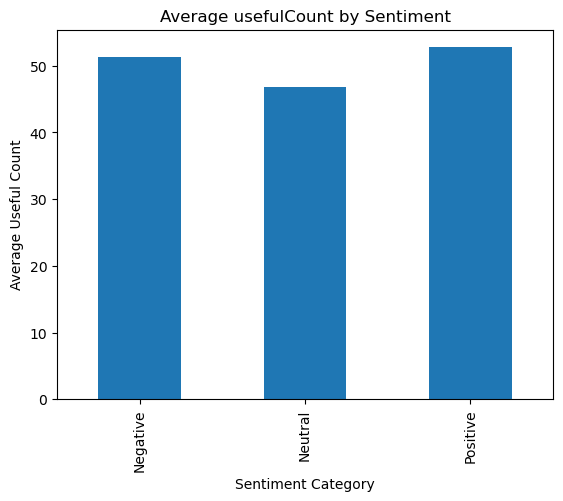

In [28]:
filtered_drug_reviews.groupby('Sentiment')['usefulCount'].mean().plot(
    kind='bar', title='Average usefulCount by Sentiment', ylabel='Average Useful Count', xlabel='Sentiment Category'
)
plt.show()

In [29]:
filtered_drug_reviews.groupby('Sentiment')['usefulCount'].mean()

Sentiment
Negative    51.287806
Neutral     46.868118
Positive    52.768617
Name: usefulCount, dtype: float64

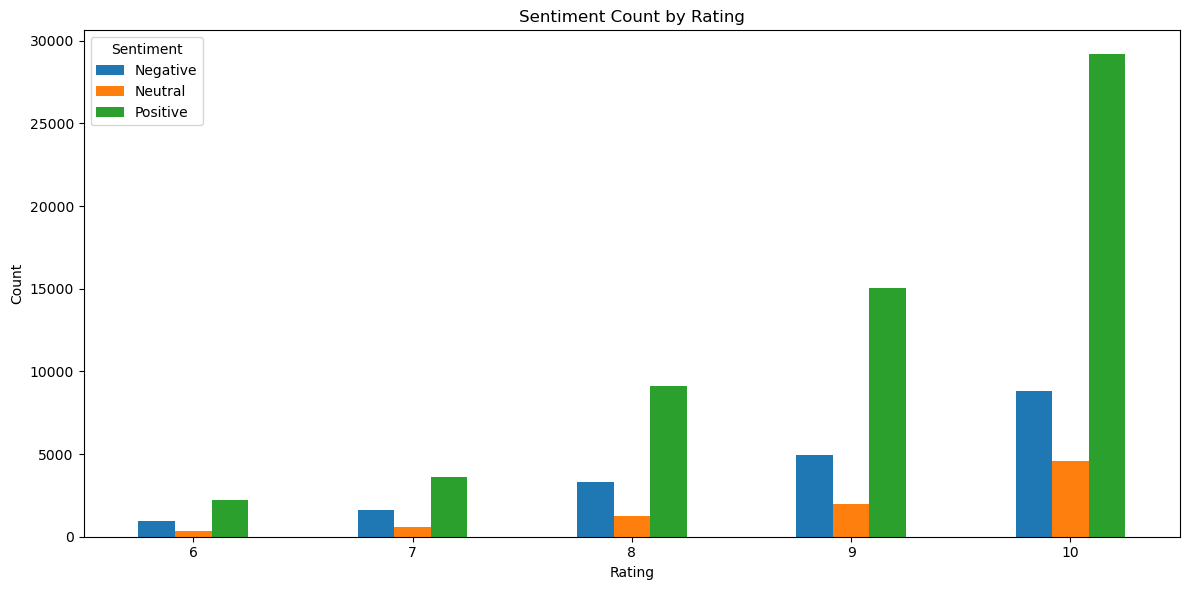

In [30]:
sentiment_rating_counts = filtered_drug_reviews.groupby(['rating', 'Sentiment']).size().unstack(fill_value=0)

sentiment_rating_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(12, 6),
)

plt.title('Sentiment Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
# Add length features
filtered_drug_reviews['effectiveness_len'] = drug_reviews['effectiveness'].apply(lambda x: len(str(x).split()))
filtered_drug_reviews['side_effects_len'] = drug_reviews['side effects'].apply(lambda x: len(str(x).split()))

# Compare average text length
filtered_drug_reviews.groupby('Sentiment')[['side_effects_len', 'effectiveness_len']].mean()

,side_effects_len,effectiveness_len
Sentiment,,
Negative,6.973878,14.021684
Neutral,3.035906,8.821270
Positive,5.918230,14.799716


In [32]:
# get cleaned tokens for each sentiment
positive_tokens = clean_and_tokenize(' '.join(filtered_drug_reviews[filtered_drug_reviews['Sentiment'] == 'Positive']['effectiveness'].dropna()))
negative_tokens = clean_and_tokenize(' '.join(filtered_drug_reviews[filtered_drug_reviews['Sentiment'] == 'Negative']['effectiveness'].dropna()))
neutral_tokens  = clean_and_tokenize(' '.join(filtered_drug_reviews[filtered_drug_reviews['Sentiment'] == 'Neutral']['effectiveness'].dropna()))

# convert to sets to find overlaps
positive_words = set(positive_tokens)
negative_words = set(negative_tokens)
neutral_words  = set(neutral_tokens)

# find overlapping words
all_common_words = (positive_words & negative_words) | (positive_words & neutral_words) | (negative_words & neutral_words)

# filter tokens to exclude common words
positive_filtered = ' '.join([w for w in positive_tokens if w not in all_common_words])
negative_filtered = ' '.join([w for w in negative_tokens if w not in all_common_words])
neutral_filtered  = ' '.join([w for w in neutral_tokens if w not in all_common_words])

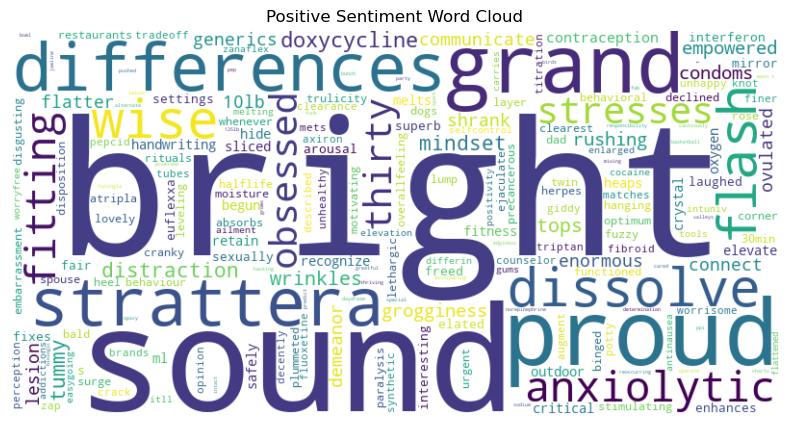

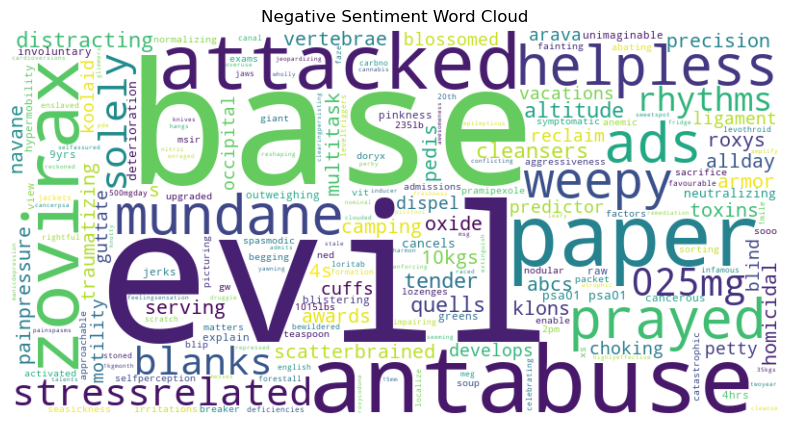

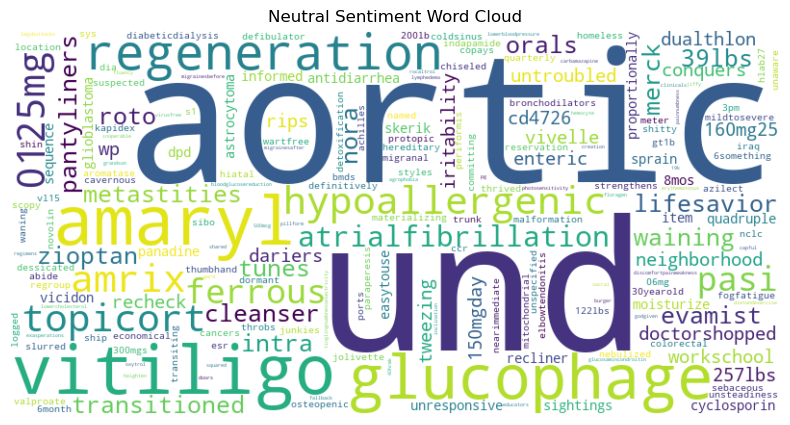

In [33]:
show_wordcloud(positive_filtered, 'Positive Sentiment Word Cloud')
show_wordcloud(negative_filtered, 'Negative Sentiment Word Cloud')
show_wordcloud(neutral_filtered,  'Neutral Sentiment Word Cloud')